Vocabulary Definitions

*   ReLU:  Function that returns 0 for negative numbers and doesn't change positive numbers.
*   Mini-batch: A small group of inputs and labels gathered together in 2 arrays. A gradient descent step is updated on this batch (rather than a whole epoch).
*   Forward pass: Applying the model to some input and computing the predictions.
*   Loss: A value that represents how well (or badly) our model is doing
*   Gradient: The derivative of the loss with respect to some parameter of the model.
*   Backward pass: Computing the gradients of the loss with respect to all model parameters.
*   Gradient descent: Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.
*   Learning rate: The size of the step we take when applying SGD to update the parameters of the model.

## Import Packages & Load Data

In [8]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
fpath = '/content/drive/MyDrive/BMI_Deep_Learning_Course/final_project/'
dataset = pd.read_csv(fpath+'data/shuffled_data.csv', index_col=0) # 952 total samples (0-951)
dataset.drop(columns=['index'], inplace=True)
dataset.head()

,Sample,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Gemellaceae;g__Gemella,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Neisseria,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Bilophila,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Stoquefichus,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,...,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruminococcus,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales_A;f__Turicibacteraceae;g__Turicibacter,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A,Condition
0,10720,0.000010,0.000011,0.000009,0.002025,0.000224,0.000649,8.900108e-07,0.019677,0.000004,...,0.000103,0.004792,0.003215,0.008747,0.001978,0.000021,0.000003,0.000016,0.000018,1
1,A019,0.000000,0.000012,0.000000,0.000000,0.106643,0.000000,0.000000e+00,0.000024,0.000023,...,0.000000,0.000000,0.010040,0.096365,0.000108,0.000000,0.000240,0.000005,0.000000,0
2,CRC.175,0.000000,0.000000,0.000000,0.000000,0.030303,0.015152,0.000000e+00,0.000000,0.000000,...,0.113636,0.000000,0.053030,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,1
3,PRISM.7776,0.000354,0.000008,0.000007,0.001121,0.003483,0.107623,6.878160e-06,0.000114,0.001418,...,0.000457,0.000011,0.009127,0.221212,0.000227,0.000003,0.000517,0.000007,0.000051,2
4,Validation.UMCG6047689,0.000008,0.000002,0.000003,0.001584,0.002361,0.030603,5.449742e-06,0.013034,0.000309,...,0.000342,0.000013,0.000073,0.127677,0.000694,0.000026,0.000063,0.000047,0.000027,2


## Helpful Functions



*   **mnist_loss**: get the distance from the probability prediction values (between 0 & 1) from the actual value (either 0 or 1) and return the mean of these values
*   **convert_to_tensor**: convert row at specific idx to a tensor 9 by 5
*   **create_tensor_classes**: given a dataset and labels for each row in the dataset, return a tuple of three lists of tensors (one for each class) ie (HealthyTensors, CancerTensors, IBDTensors)
*   **mnist_distance & square_distance** both return the distance between two points (one absolute and one squared)
*   **isIBD, isCancer, isHealthy**: all use either of the above distance functions to determine a given images class by comparing it to all three average images for each class





Given a row (ie sample) in the dataset, convert that sample to an array of pixels (9 rows by 5 columns) where each cell represents the abundency of 1 out of the 45 different selected micrbiota genuses...

In [18]:
# SIGMOID FUNCTION: Always outputs a number between 0 and 1...
# high positive numbers will ALWAYS be =~1 while high negatives will ALWAYS be =~0
# numbers between -2 & 2 are between 0.119 and 0.88 (with 0 at 0.5)
# sigmoid(x) = 1/(1+torch.exp(-x))

# update mnist_loss to first apply sigmoid function to inputs...
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() # see above for explanation

    # if target is supposed to =1, return distance from it to target (eg. if 0.8 then distance=0.2)
    # if target is supposed to =0, do the same thing but opposite (eg. if 0.8 then distance=0.8)
    # apply this to the entire list of predictions and return the mean of that list (ie the loss!)
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [19]:
def convert_to_tensor(dataset,index):

  sample = list(dataset.iloc[index])

  # create a tensor with 9 rows and 5 columns (5*9=45)
  tensor = torch.tensor(sample)
  tensor = tensor.view(9, 5)

  return tensor

In [20]:
def create_tensor_classes(dataset, labels):
  IBD_tensors = []
  Healthy_tensors = []
  Cancer_tensors = []

  labels = list(labels)
  for row in range(0,len(dataset)):
    tensor = convert_to_tensor(dataset,row)
    if labels[row] == 0:
      Healthy_tensors.append(tensor)
    elif labels[row] == 2:
      IBD_tensors.append(tensor)
    elif labels[row] == 1:
      Cancer_tensors.append(tensor)
    else:
      print('ERROR')

  #(len(Healthy_tensors), len(Cancer_tensors), len(IBD_tensors))
  return (Healthy_tensors, Cancer_tensors, IBD_tensors)

Ultimately, a function, `has_IBD`, should decide if an arbitrary microbiota has IBD or not by deciding which (out of healthy vs IBD averages) this  image is closer to. To do this, the function below will calculate the mean absolute error using an expression very similar to the one used in General Exploration Section...

In [21]:
# 2 general types of distance functions
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2)) # absolute value
def square_distance(a,b): return ((a-b)**2).mean((-1,-2)).sqrt() # squared + square root

# functions to use above distance functions to determine class
# ie the closest average image is that images class!!!
def is_IBD(x, meanIBD, meanHealthy, meanCancer, distance_func):
  no_Healthy = distance_func(x,meanIBD) < distance_func(x,meanHealthy)
  no_Cancer = distance_func(x,meanIBD) < distance_func(x,meanCancer)
  return torch.logical_and(no_Healthy, no_Cancer)

def is_Cancer(x, meanIBD, meanHealthy, meanCancer, distance_func):
  no_Healthy = distance_func(x,meanCancer) < distance_func(x,meanHealthy)
  no_IBD = distance_func(x,meanCancer) < distance_func(x,meanIBD)
  return torch.logical_and(no_Healthy, no_IBD)

# def is_Healthy(x): return mnist_distance(x,meanHealthy) < mnist_distance(x,meanIBD)
def is_Healthy(x, meanIBD, meanHealthy, meanCancer, distance_func):
  no_IBD = distance_func(x,meanHealthy) < distance_func(x,meanIBD)
  no_Cancer = distance_func(x,meanHealthy) < distance_func(x,meanCancer)
  return torch.logical_and(no_IBD, no_Cancer)

## Split Data into Train & Test Sets

(source: https://medium.com/artificialis/why-how-we-split-train-valid-and-test-fb4d6746ede)

Creates 2 dataframes by spliting the data 0.80 and 0.20 (does not shuffle because data has already been shuffled in previous steps)...

*   Training Set: X_train, y_train (666 images)
*   Validation Set: X_valid, y_valid (143 images)



In [22]:
# Setup random seed
np.random.seed(42)

# Create X and y
X = dataset.drop(["Sample", "Condition"], axis=1)
y = dataset["Condition"]

In [23]:
start_train_idx = 0
end_train_idx = round(len(dataset)*0.80)

start_valid_idx = end_train_idx
end_valid_idx = len(dataset)

In [24]:
X_train = X[start_train_idx:end_train_idx]
X_train.reset_index(drop=True,inplace=True)

X_valid = X[start_valid_idx:end_valid_idx]
X_valid.reset_index(drop=True,inplace=True)

y_train = y[start_train_idx:end_train_idx]
y_train.reset_index(drop=True,inplace=True)

y_valid = y[start_valid_idx:end_valid_idx]
y_valid.reset_index(drop=True,inplace=True)

Check the porportion of classes in each dataset...

In [25]:
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{y.value_counts() / len(dataset)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{y_train.value_counts() / len(y_train)}\n\n'+
      f'PROPORTION OF TARGET IN THE VALIDATION SET\n{y_valid.value_counts() / len(y_valid)}')

PROPORTION OF TARGET IN THE ORIGINAL DATA
Condition
0    0.506303
1    0.283613
2    0.210084
Name: count, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
Condition
0    0.510499
1    0.276903
2    0.212598
Name: count, dtype: float64

PROPORTION OF TARGET IN THE VALIDATION SET
Condition
0    0.489474
1    0.310526
2    0.200000
Name: count, dtype: float64


## BASELINE MODEL 0: Heuristic Model Comparing to a Class Average with Mean Squared Error

Using pixel similarity as done in the code below produces a result but does not get better and learn because there is not any weight assignment, or any way of improving based on testing the effectiveness of a weight assignment (ie the pixel similarity approach cannot be improved by modifying a set of parameters).

Each of the three objects below is a tuple with three lists inside: The first list (tuple[0]) is a list of HEALTHY tensors while the second list (tuple[1]) is a list of IBD tensors and the third list (tuple[2]) is a list of Cancer tensor) every tensor in all lists has a shape of [9,5] to hold all 45 microbiota of interest...

In [27]:
# returns (Healthy_tensors, IBD_tensors, Cancer_tensors)
train_classes = create_tensor_classes(X_train, y_train)
valid_classes = create_tensor_classes(X_valid, y_valid)

In [28]:
# same thing but creates a new type (rather than being in a list the tensors are stacked)
stacked_IBD_train = torch.stack(train_classes[2])
stacked_Cancer_train = torch.stack(train_classes[1])
stacked_Healthy_train = torch.stack(train_classes[0])

stacked_IBD_valid = torch.stack(valid_classes[2])
stacked_Cancer_valid = torch.stack(valid_classes[1])
stacked_Healthy_valid = torch.stack(valid_classes[0])

# get the mean tensor of each stacked list...
meanIBD = stacked_IBD_train.mean(0)
meanCancer = stacked_Cancer_train.mean(0)
meanHealthy = stacked_Healthy_train.mean(0)

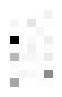

In [29]:
show_image(meanHealthy);

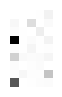

In [30]:
show_image(meanCancer);

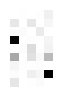

In [31]:
show_image(meanIBD);

In [32]:
#valid__dist_Healthy = mnist_distance(stacked_Healthy_valid, meanHealthy)
valid__dist_Healthy = square_distance(stacked_Healthy_valid, meanHealthy) # get difference between mean shape and a subset of tensors (valid)

# there are 68 valid images so there should be 68 numbers showing the
# difference between each of the 68 images and the mean image...
valid__dist_Healthy, valid__dist_Healthy.shape

(tensor([0.0383, 0.0131, 0.0286, 0.0145, 0.0234, 0.0342, 0.0332, 0.0881, 0.0148,
         0.0163, 0.0375, 0.0123, 0.0290, 0.0236, 0.0575, 0.0156, 0.0232, 0.0249,
         0.0206, 0.0123, 0.0558, 0.0334, 0.0271, 0.0242, 0.0156, 0.0164, 0.0284,
         0.0237, 0.0284, 0.0320, 0.0479, 0.0159, 0.0172, 0.0200, 0.0106, 0.0121,
         0.0424, 0.0234, 0.0349, 0.0753, 0.0181, 0.0302, 0.0508, 0.0198, 0.0335,
         0.0623, 0.0274, 0.0321, 0.0213, 0.0170, 0.0496, 0.0121, 0.0393, 0.0267,
         0.0162, 0.0142, 0.0162, 0.0515, 0.0138, 0.0469, 0.0218, 0.0418, 0.0388,
         0.0283, 0.0308, 0.0171, 0.0515, 0.0309, 0.0250, 0.0200, 0.0709, 0.0171,
         0.0232, 0.0224, 0.0232, 0.0258, 0.0629, 0.0351, 0.0232, 0.0207, 0.0211,
         0.0441, 0.0132, 0.0196, 0.0129, 0.0167, 0.0418, 0.0232, 0.0875, 0.0160,
         0.0274, 0.0200, 0.0424]),
 torch.Size([93]))

In [33]:
# an example of the output of getting all correct predictions (ie True values) of the image being healthy
is_Healthy(stacked_Healthy_valid, meanIBD, meanHealthy, meanCancer, square_distance)

tensor([False,  True,  True,  True,  True,  True, False, False, False,  True,
        False,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True, False, False, False,  True,  True,
        False,  True,  True, False,  True,  True, False,  True,  True, False,
         True, False, False,  True,  True, False,  True, False, False, False,
        False,  True, False, False,  True, False, False, False,  True, False,
         True,  True, False,  True, False,  True, False, False, False, False,
        False,  True,  True, False,  True,  True, False, False, False, False,
        False,  True,  True,  True,  True, False, False,  True, False, False,
         True, False, False])

In [34]:
accuracy_Healthy = is_Healthy(stacked_Healthy_valid, meanIBD, meanHealthy, meanCancer, mnist_distance).float().mean()
print("Baseline Health Detection Accuracy: " + str(accuracy_Healthy))
accuracy_Cancer = is_Cancer(stacked_Cancer_valid, meanIBD, meanHealthy, meanCancer, mnist_distance).float().mean()
print("Baseline Cancer Detection Accuracy: " + str(accuracy_Cancer))
accuracy_IBD = is_IBD(stacked_IBD_valid, meanIBD, meanHealthy, meanCancer, mnist_distance).float().mean()
print("Baseline IBD Detection Accuracy: " + str(accuracy_IBD))

Baseline Health Detection Accuracy: tensor(0.3441)
Baseline Cancer Detection Accuracy: tensor(0.4746)
Baseline IBD Detection Accuracy: tensor(0.8158)


In [35]:
# sum up true values for each class to get the overall accuracy of each model
accuracy_Healthy = is_Healthy(stacked_Healthy_valid, meanIBD, meanHealthy, meanCancer, square_distance).float().mean()
print("Baseline Health Detection Accuracy: " + str(accuracy_Healthy))
accuracy_Cancer = is_Cancer(stacked_Cancer_valid, meanIBD, meanHealthy, meanCancer, square_distance).float().mean()
print("Baseline Cancer Detection Accuracy: " + str(accuracy_Cancer))
accuracy_IBD = is_IBD(stacked_IBD_valid, meanIBD, meanHealthy, meanCancer, square_distance).float().mean()
print("Baseline IBD Detection Accuracy: " + str(accuracy_IBD))

Baseline Health Detection Accuracy: tensor(0.4946)
Baseline Cancer Detection Accuracy: tensor(0.3898)
Baseline IBD Detection Accuracy: tensor(0.7632)


## Notes on SGM (DONT NEED THIS PROBABLY DELETE)

Instead of trying to find similarity between an image and an "ideal image" (as done in the baseline section above), look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels (ie microbiota) most likely to be black for a particular category...*italicized text*

In [ ]:
# can be represented as a function and set of weight values for each category— e.g. the probability of being Cancer:
def pr_cancer(x,w):
  return (x*w).sum()

Assume `x` is the image represented as a vector (ie with all rows stacked up end to end into a single long line) and weights are a vector `w`...With this function above we need a way to update the weights to make them a little better, then we can repeat this step many times, to make the weights better and better.

**Goal**: Find specific values for vector `w` that causes the result of our function to be high for those images that are actually Cancer, and low for images that are not.

Searching for the best vector `w` is a way to search for the best function for recognising Cancer (because we are not yet using a deep neural network, we are limited by what our function can actually do which will be fixed later).

To turn this function into a machine learning classifier...

1. *Initialize*  weights (usually random
2. For each image, use these weights to *predict* whether it appears to be a Cancer or not Cancer
3. Based on these predictions, calculate how good the model is (its *loss*) (in general, the convention is that smaller loss is better)
4. Calculate the *gradient*, which measures for each weight, how changing that weight would change the loss
5. *Step* (that is, change by increasing or decreasing by a little bit) all the weights based on that calculation
6. Go back to the step 2, and *repeat* the process.
7. Iterate until you decide to *stop* the training process (usually stop either due to time constraints or because the accuracy got worse)

Function has lots of weights to be adjusted, so when the derivative is calculated, we won't get back one number but lots of them (a gradient for every weight). You can calculate the derivative with respect to one weight using Pytorch, and treat all the others as constant, then repeat that for each other weight.

In [ ]:
# pick a tensor value which we want gradients at...
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

`requires_grad_` is used to tell PyTorch that we want to calculate gradients with respect to the variable at that value (ie tags variable so PyTorch will remember to keep track of how to compute gradients of the other, direct calculations on it you will ask for).

Usually the "gradient" ie derivative of a function is just another function...HOWEVER, in deep learning, "gradients" are the _value_ of a function's derivative at a particular argument value. Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

In [ ]:
def f(x):
  return x**2
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [ ]:
# tell pytorch to calculate gradients for us
# NOTE backward = calculate gradient
yt.backward()

In [ ]:
# view gradients by checking the grad attribute of a tensor
xt.grad

tensor(6.)

NEXT - Multiply the gradient by a small number, called the *learning rate* (LR) which is usually between 0.001 and 0.1 (generally select by trying a few values). Adjust parameters using function: w -= gradient(w) * lr

Known as *stepping* your parameters, using an *optimizer step*. Subtracting the `gradient * lr` from the parameter to update it allows us to adjust the parameter in the direction of the slope by increasing the parameter when the slope is negative and decreasing the parameter when the slope is positive to _minimize_ the loss.

In [ ]:
# mse = mean squared error = subtract the target value from each prediction and square the resulting value, then get the average of all these values
def mse(preds, targets): return ((preds-targets)**2).mean()

In [ ]:
xt = tensor(3.).requires_grad_()

In [ ]:
def f(x): return x**2

In [ ]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [ ]:
xt.grad

tensor(6.)

## Create a fastai Dataset Object for Train and Test Data



*   **train_data_X/valid_data_X**: a concatenated list of all classes in the training set (ie [stackedHealthy, stackedCancer, stackedIBD])
*   **train_data_Y/valid_data_Y**: a tensor list containing the labels associated with each tensor image in train_data_Y
*   **dset/valid_dset**: a Dataset object for the training data, each item in this object is a tuple with (tensor, class_id)



Concatenate all tensor classes into a single tensor, and also change from a list of matrices (rank-3 tensor) to a list of vectors (a rank-2 tensor) using `view` (a PyTorch method that changes the shape of a tensor without changing its contents) - `-1` is a special parameter to `view` that means "make this axis as big as necessary to fit all the data"...

**NOTE I CHANGED LABELS SO THAT CANCER=1 AND IBD & HEALTHY = 0**

In [51]:
# should be 762 (389+211+162) images total with 45 microbiota in each image...
train_data_X = torch.cat([stacked_Healthy_train, stacked_Cancer_train, stacked_IBD_train]).view(-1, 9*5) # use 9*5 because that is the area of our tensors!

# 0 = Healthy, 1 = Cancer, 2 = IBD
train_data_Y = tensor( [1]*len(train_classes[0]) + [0]*len(train_classes[1]) + [0]*len(train_classes[2]) ).unsqueeze(1)
train_data_X.shape,train_data_Y.shape

# Dataset in PyTorch is required to return a tuple of (x,y) when indexed
# zip function, when combined with list, provides a way to get this Dataset functionality...
dset = list(zip(train_data_X,train_data_Y))
dset[0] # tuple of (45 microbiota, class id)

(tensor([0.0000e+00, 1.2242e-05, 0.0000e+00, 0.0000e+00, 1.0664e-01, 0.0000e+00,
         0.0000e+00, 2.4485e-05, 2.2736e-05, 7.8001e-03, 0.0000e+00, 4.3023e-04,
         0.0000e+00, 8.6221e-04, 0.0000e+00, 5.1160e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 4.2551e-03, 0.0000e+00, 4.0225e-05, 6.3083e-03, 0.0000e+00,
         2.2708e-02, 4.0225e-05, 0.0000e+00, 1.3785e-02, 1.4009e-03, 9.7064e-04,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.9557e-04,
         0.0000e+00, 0.0000e+00, 1.0040e-02, 9.6365e-02, 1.0843e-04, 0.0000e+00,
         2.3960e-04, 5.2467e-06, 0.0000e+00]),
 tensor([1]))

In [52]:
valid_data_X = torch.cat([stacked_Healthy_valid, stacked_Cancer_valid, stacked_IBD_valid]).view(-1, 9*5)
valid_data_Y = tensor( [1]*len(valid_classes[0]) + [0]*len(valid_classes[1]) + [0]*len(valid_classes[2]) ).unsqueeze(1)
valid_dset = list(zip(valid_data_X,valid_data_Y))

## Implementing Loss Function (PROBABLY DELETE)

---



In [63]:
# initialize a random weight for every pixel (ie the *initialize* step in 7-step process):
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

In [ ]:
# mse = mean squared error = subtract the target value from each prediction and square the resulting value, then get the average of all these values
def mse(preds, targets): return ((preds-targets)**2).mean()

In [66]:
weights = init_params((9*5,1))
weights.shape

torch.Size([45, 1])

Because the function `weights*pixels` is not flexible enough since it is always equal to 0 when pixels=0 (i.e., its *intercept* is 0), we need to define the b by initializing a random number from `y=w*x+b`

In [68]:
bias = init_params(1) # PARAMETERS = weights + bias
bias

tensor([-0.1273], requires_grad=True)

In [70]:
(train_data_X[0]*weights.T).sum() + bias # calculate a prediction for ONE image

tensor([-0.6152], grad_fn=<AddBackward0>)

In [72]:
# calculate predictions for ALL images in training data...
def linear1(xb):
  return xb@weights + bias # where @ is the operator for matrix multiplication
preds = linear1(train_data_X)
preds.shape # calculates predictions for ALL 762 images

torch.Size([762, 1])

In [74]:
torch.min(preds)

tensor(-0.8196, grad_fn=<MinBackward1>)

In [ ]:
# To check accuracy (decide if an output is Cancer or not) - check whether it's greater than 0.0
# allows accuracy for each image to be calculated (using broadcasting, so no loops!) with:
corrects = (preds>0.0).float() == train_data_Y
corrects

In [ ]:
corrects.float().mean().item()

0.2957957983016968

In [ ]:
# what is the change in accuracy for a small change in one of the weights
# DO NOT calculate gradients hence no_grad
with torch.no_grad():
  weights[0] *= 1.0001

preds = linear1(train_data_X) # returns the SAME accuracy so MAKES NO DIFFERENCE!!!
((preds>0.0).float() == train_data_Y).float().mean().item()


0.2957957983016968

The results above show that in order to improve our model using SGD, and in order to calculate gradients we need some *loss function* that represents how good the model is because the gradients are a measure of how that loss function changes with small tweaks to the weights.

We need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss, ie if the image is correctly classified as cancer then the score is a little higher or if the correct answer was not cancer than the score is a little lower.

The loss function receives not the images themselves, but the predictions from the model, so make one argument, `prds`, of values between 0 and 1, where each value is the prediction that an image is Cancer. It is a vector (i.e., a rank-1 tensor), indexed over the images.

The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another argument, `trgts`, with values of 0 or 1 which tells whether an image actually is Cancer or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

So, for instance, suppose we had three images which we knew were one cancer, one non cancer and one cancer. And suppose our model predicted with high confidence (`0.9`) that the first was cancer, with slight confidence (`0.4`) that the second was cancer, and with fair confidence (`0.2`), but incorrectly, that the last was not cancer. This would mean our loss function would receive these values as its inputs:

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [ ]:
# loss function that measures distance between `predictions` and `targets`...
# torch.where(a,b,c)` is the same as the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))]` EXCEPT it works on tensors, at C/CUDA speed
# ie measures how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, then takes the mean of all those distances
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
torch.where(trgts==1, 1-prds, prds) # try this out on example above

tensor([0.1000, 0.4000, 0.8000])

Function above returns a lower number when predictions are more accurate, when accurate predictions are more confident (higher absolute values), and when inaccurate predictions are less confident. ALWAYS assume that a lower value of a loss function is better. Since we need a scalar for the final loss, `mnist_loss` takes the mean of the previous tensor:

In [ ]:
mnist_loss(prds,trgts)

tensor(0.4333)

## Adding Sigmoid Function (JUST WRITING)

One problem with `mnist_loss` in previous section is that it assumes predictions are always between 0 and 1 which is not always the case...Use the sigmoid function to make this the case...

Having defined a loss function, try to answer why a loss function was needed given that overall accuracy is already a metric used to measure performance?

The key difference is that accuracy is a metric used to drive human understanding and the loss is to drive automated learning. To drive automated learning, the loss must be a function that has a meaningful derivative with no big flat sections and/or large jumps, but instead must be reasonably smooth. A loss function should therefore respond to small changes in confidence level and also means that sometimes it does not really reflect exactly what we are trying to achieve, but is rather a compromise between our real goal and a function that can be optimized using its gradient. The loss function is calculated for each item in our dataset, and then at the end of an epoch the loss values are all averaged and the overall mean is reported for the epoch.

Metrics, on the other hand, are the numbers that we really care about. These are the values that are printed at the end of each epoch that tell us how our model is really doing. It is important that we learn to focus on these metrics, rather than the loss, when judging the performance of a model.

## SGD & Mini-Batches (JUST WRITING)

Understanding the optimization step (ie changing/updating the weights based on gradients)

Calculate the average loss for a few data items at a time which is called a *mini-batch* (number of data items in mini-batch is called  *batch size*). A larger batch size means that you will get a more accurate and stable estimate of  dataset's gradients from loss function, but it takes longer, and you will process fewer mini-batches per epoch.

Since we get better generalization if we can vary things during training, one simple and effective thing we can vary is what data items we put in each mini-batch. Rather than enumerating our dataset in order for every epoch, we randomly shuffle it on every epoch before creating mini-batches. PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader` which can take any Python collection and turn it into an iterator over mini-batches, like so:

## Mannual Training (Putting it all Together)

In [53]:
# initialize random weight matrix of size (9 by 5) and random single bias number
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

def mse(preds, targets):
  return ((preds-targets)**2).mean()

def linear1(xb): # multiply a given tensor image by the weight matrix and add bias
  return xb@weights + bias

In [76]:
# reinitialize parameters
weights = init_params((9*5,1))
bias = init_params(1)

In [77]:
# create a Dataloader from a Dataset
dl = DataLoader(dset, batch_size=32, shuffle=True)

valid_dl = DataLoader(valid_dset, batch_size=32, shuffle=True)
xb,yb = first(dl) # first batch of 32 samples (xb=tensors and yb=labels)
xb.shape,yb.shape

(torch.Size([32, 45]), torch.Size([32, 1]))

In [78]:
# STEP 1: create a mini-batch for testing of size 5...
#batch = train_data_X[387:392] # get first 2 items belonging to Healthy images and last 3 belonging to Cancer
batch = xb
batch.shape

torch.Size([32, 45])

In [ ]:
# STEP 2: MAKE PREDICTIONS
preds = linear1(batch) # linear1(xb): return xb@weights + bias
preds
#torch.max(preds)

In [81]:
# STEP 3: CALCULATE LOSS (by comparing prediction to target values)
loss = mnist_loss(preds, yb) # loss = torch.where(targets==1, 1-predictions, predictions).mean()
loss

tensor(0.5567, grad_fn=<MeanBackward0>)

In [82]:
# STEP 4: CALCULATE GRADIENTS FROM LOSS
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([45, 1]), tensor(0.0018), tensor([0.1334]))

In [83]:
## Put steps 1,2,3 & 4 together into a single function..
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

# Now test the function above...
calc_grad(batch, yb, linear1)
weights.grad.mean(),bias.grad

(tensor(0.0035), tensor([0.2669]))

NOTE THE ABOVE DOES NOT WORK because if we call the exact same two final lines above (ie calc_grad and weights...ect) then the gradients change which should not happen because it adds the gradients of the loss function to the already obtrained gradients. To fix this, we must set the current gradient to 0 before stepping...

In [84]:
weights.grad.zero_()
bias.grad.zero_();

FINALLY, we update weights and biases based on the gradient and LR. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [85]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [86]:
# gives the following function to calculate validation accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

batch_accuracy(linear1(batch), yb)

tensor(0.2188)

In [87]:
## puting batches together...
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1) # this is the starting point!!! not very good

0.3156

In [88]:
# train for one epoch to see if the accuracy above improves...
lr = 0.5
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6889

In [90]:
# do more!!!
for i in range(4):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.6896 0.6889 0.6896 0.6892 

## Optimizer

Create an object that will handle the SGD steps above automatically which, in PyTorch, is called an *optimizer*.

The first step is to replace the `linear1` function with PyTorch's `nn.Linear` module (*module* is object of a class that inherits from the PyTorch `nn.Module` class). Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

`nn.Linear` does the same thing as `init_params` and `linear` together. It contains both the *weights* and *biases* in a single class. Here's how to replicate the model from the section above:

In [78]:
linear_model = nn.Linear(9*5,1)
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 45]), torch.Size([1]))

In [ ]:
# use the information above to create an optimizer
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr) # create an optimizer by passing in the models parameters

# now training loop can be simplified
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [ ]:
# validation function stays the same
validate_epoch(linear_model)

# put training loop in a function to make things simpler
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [ ]:
train_model(linear_model, 20)

0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 

In [ ]:
## SGD class does the same thing as BasicOptim...
linear_model = nn.Linear(9*5,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 0.6375 

## TRAIN LINEAR MODEL

In [38]:
# can also use Learner.fit instead of train_model
# to create a Learner, first create a DataLoaders by passing in training and valid DataLoaders
dls = DataLoaders(dl, valid_dl)


NameError: name 'dl' is not defined

In [54]:
# To create a Learner without using an application (such as `vision_learner`)...
# pass in the DataLoaders, model, the optimization function (which will be passed the parameters), loss function, and optionally any metrics to print...
learn = Learner(dls, nn.Linear(9*5,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [55]:
learn.fit(100) # now call fit

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.499767,0.499414,0.510526,00:00
1,0.499786,0.499414,0.510526,00:00
2,0.499782,0.499415,0.510526,00:00
3,0.499806,0.499415,0.510526,00:00
4,0.499824,0.499415,0.510526,00:00
5,0.499816,0.499416,0.510526,00:00
6,0.499848,0.499416,0.510526,00:00
7,0.499871,0.499417,0.510526,00:00
8,0.499866,0.499417,0.510526,00:00
9,0.499866,0.499418,0.510526,00:00


## Adding Non-Linearity

Add something nonlinear between two linear classifiers in order to make a basic neural network

In [53]:
# create a Dataloader from a Dataset
dl = DataLoader(dset, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=32, shuffle=True)

# can also use Learner.fit instead of train_model
# to create a Learner, first create a DataLoaders by passing in training and valid DataLoaders
dls = DataLoaders(dl, valid_dl)

In [40]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

# initialize random weight matrix of size (9 by 5) and random single bias number
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

def mse(preds, targets):
  return ((preds-targets)**2).mean()

def linear1(xb): # multiply a given tensor image by the weight matrix and add bias
  return xb@weights + bias

In [83]:
# entire definition of a simple neural net (2 linear classifiers with a max function between them)
# note `w1` and `w2` are weight tensors, and `b1` and `b2` are bias tensors
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [90]:
w1 = init_params((9*5,30)) # matrix of 45 but with 30 layers!
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

Key point in code above is that `w1` has 30 output activations (which means that `w2` must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels (can change that `30` to anything you like, to make the model more or less complex).

The function `res.max(tensor(0.0))` is called a *rectified linear unit*, also known as *ReLU* which basically replaces every negative number with a zero (also available in PyTorch as `F.relu`)

Amazingly enough, it can be mathematically proven that this function can solve any computable problem to an arbitrarily high level of accuracy, if you can find the right parameters for `w1` and `w2` and if you make these matrices big enough. This is known as the *universal approximation theorem* and the three lines of code above are known as *layers*. The first and third are known as *linear layers*, and the second line of code is known variously as a *nonlinearity*, or *activation function*.





In [41]:
# replace above code with something simpler
simple_net = nn.Sequential(
    nn.Linear(9*5,15),
    nn.BatchNorm1d(15),
    nn.ReLU(),
    nn.Linear(15,1)
)

`nn.Sequential` above creates a module that will call each of the listed layers or functions in turn.

`nn.ReLU` is a PyTorch module that does exactly the same thing as the `F.relu` function (most functions that can appear in a model also have identical forms that are modules). Because `nn.Sequential` is a module, we can get its parameters, which will return a list of all the parameters of all the modules it contains. Trying this out, we'll use a lower learning rate and a few more epochs (since this is a more complex model)...

SuggestedLRs(valley=0.3630780577659607)

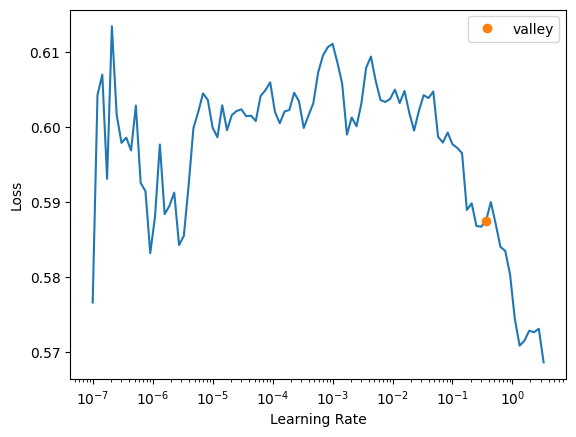

In [56]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.lr_find()
#learn.fit(10, 0.1)

In [134]:
learn.save('/content/drive/MyDrive/BMI_Deep_Learning_Course/final_project/cancer_model2')

Path('/content/drive/MyDrive/BMI_Deep_Learning_Course/final_project/cancer_model2.pth')

In [57]:
learn.fit(100, 0.363)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.562364,0.493609,0.510526,00:00
1,0.533915,0.493701,0.510526,00:00
2,0.520370,0.499140,0.500000,00:00
3,0.513502,0.501563,0.494737,00:00
4,0.504843,0.501918,0.500000,00:00
5,0.503892,0.500857,0.494737,00:00
6,0.499352,0.497577,0.500000,00:00
7,0.496634,0.498848,0.494737,00:00
8,0.492761,0.496859,0.489474,00:00
9,0.489547,0.484930,0.521053,00:00


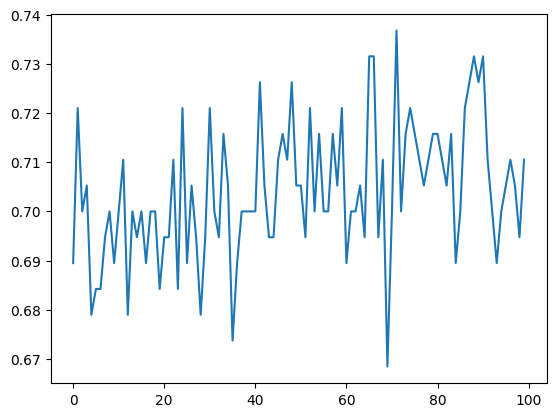

In [133]:
# training process is recorded in `learn.recorder`, with table of output stored in `values` attribute
# allows us to plot the accuracy over training as... (note doesn't show the 40 lines of output here to save room)
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
# view final accuracy...
learn.recorder.values[-1][2]

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
2. A way to find the best set of parameters for any function (stochastic gradient descent)

This is why deep learning can do things which seem rather magical, such fantastic things. Believing that this combination of simple techniques can really solve any problem is a big step to take but try it out for yourself to prove it!!!

There is no need to stop at just two linear layers since you can many more as long as there is a nonlinearity between each pair of linear layers. However, the deeper the model gets, the harder it is to optimize the parameters in practice.

Since a single nonlinearity with two linear layers is enough to approximate any function, why would we use deeper models? The reason is performance... a deeper model with more layers does not need as many parameters, ie we can just use smaller matrices with more layers, and get better results than with few layer larger matrices (means that we can train the model more quickly, and it will take up less memory).

Training an 18-layer model using the same approach as in the beginning...

## Vision Learner Model

In [136]:
def label_func(f):
  label = str(f)[-5]
  if int(label)==1:
    return 1
  else:
    return 0
  #return int(label)

In [137]:
fnames = get_image_files(fpath+"data/images")
len(fnames)

952

In [138]:
dls = ImageDataLoaders.from_name_func(path = fpath+"data/images", fnames=fnames, train="train", valid="valid", bs=64, label_func=label_func)

In [139]:
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.543098,19.386215,0.747368,02:08


## Tabular Learner Model

In [32]:
train_indices = list(range(start_train_idx, end_train_idx))
valid_indices = list(range(start_valid_idx, end_valid_idx))

splits = (L(train_indices), L(valid_indices))

In [33]:
from fastai.tabular.all import *

bacteria_names = list(dataset.columns)[1:-1]
target_var = dataset.columns[-1]

In [35]:
dataset_cancer = dataset.copy()
dataset_cancer['Condition'].replace(2, 0, inplace=True)

In [38]:
to = TabularPandas(dataset_cancer, cont_names = bacteria_names, y_names=target_var, splits=splits, y_block = CategoryBlock)
dls = to.dataloaders(bs=64)
to.xs.iloc[:2]

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Staphylococcales;f__Gemellaceae;g__Gemella,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Neisseriaceae;g__Neisseria,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Bilophila,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Roseburia,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Coprobacillaceae;g__Stoquefichus,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides,d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Veillonellales;f__Veillonellaceae;g__Veillonella,...,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Eggerthellaceae;g__Eggerthella,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruminococcus,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__Blautia_A,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Prevotella,d__Bacteria;p__Desulfobacterota_I;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio,d__Bacteria;p__Firmicutes;c__Bacilli;o__Haloplasmatales_A;f__Turicibacteraceae;g__Turicibacter,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus,d__Bacteria;p__Firmicutes_C;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium_A
0,0.00001,0.000011,0.000009,0.002025,0.000224,0.000649,8.900108e-07,0.019677,0.000004,0.001267,...,0.000123,0.000103,0.004792,0.003215,0.008747,0.001978,0.000021,0.000003,0.000016,0.000018
1,0.00000,0.000012,0.000000,0.000000,0.106643,0.000000,0.000000e+00,0.000024,0.000023,0.007800,...,0.000296,0.000000,0.000000,0.010040,0.096365,0.000108,0.000000,0.000240,0.000005,0.000000


SuggestedLRs(valley=0.002511886414140463)

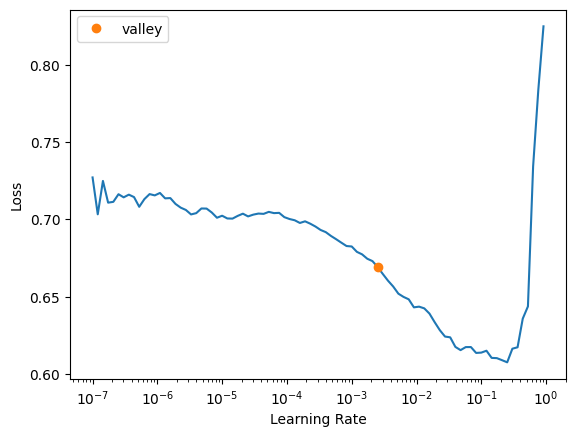

In [40]:
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find()


In [41]:
learn.fit(5, 0.0025)

epoch,train_loss,valid_loss,accuracy,time
0,0.690663,0.681794,0.657895,00:00
1,0.606624,0.694360,0.510526,00:00
2,0.541518,0.702753,0.505263,00:00
3,0.491815,0.721828,0.531579,00:00
4,0.440530,0.658250,0.615789,00:00
